In [22]:
# Import required libraries
import pygetwindow as gw
import pyautogui
from PIL import Image
import numpy as np

In [36]:
# Find the Bejeweled 3 window and get its position and size
window_title = 'Bejeweled 3'
window = None
for w in gw.getAllWindows():
    if window_title.lower() in w.title.lower():
        window = w
        break
if window is None:
    raise Exception(f'Window titled "{window_title}" not found!')
left, top, width, height = window.left, window.top, window.width, window.height
print(f'Window position: ({left}, {top}), size: ({width}x{height})')

Window position: (-7, 0), size: (816x639)


In [37]:
left += 270  # Adjust for window border
top += 70 # Adjust for window title bar
# Define the region to capture the game area
width -= 310  # Adjust for window border
height -= 130  # Adjust for window title bar and bottom border

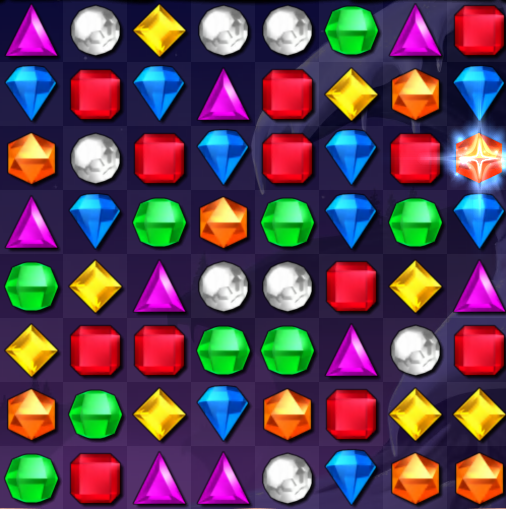

In [38]:
# Take a screenshot of the Bejeweled 3 window region
screenshot = pyautogui.screenshot(region=(left, top, width, height))
display(screenshot)


In [39]:
from collections import defaultdict
import numpy as np

grid_width = 64
grid_height = 64
grid_columns = 8
grid_rows = 8


color_bucket_size = 10  # Size of each color bucket in RGB space
def adjust_to_color_bucket(color):
    # Adjust each channel to the nearest color bucket
    return tuple((c // color_bucket_size) * color_bucket_size for c in color)
def avg_color(pixels):
    # Calculate the average for each channel
    arr = np.array(pixels)
    return tuple(int(arr[:, i].mean()) for i in range(3))

def gather_game_grid(screenshot, grid_width, grid_height, grid_columns, grid_rows):
    game = list()    
    # add a dot at the center of each grid cell
    for row in range(grid_rows):
        _rowArray = list()
        for col in range(grid_columns):
            x_center = col * grid_width + grid_width // 2
            y_center = row * grid_height + grid_height // 2
            # Collect a 3x3 grid of pixels around the center
            pixels = []
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    x = x_center + dx
                    y = y_center + dy
                    if 0 <= x < screenshot.width and 0 <= y < screenshot.height:
                        pixels.append(screenshot.getpixel((x, y)))
            if pixels:
                color = adjust_to_color_bucket(avg_color(pixels))
            else:
                color = (0, 0, 0)
            _rowArray.append(color)
        game.append(_rowArray)
            
    return game
game_grid = gather_game_grid(screenshot, grid_width, grid_height, grid_columns, grid_rows)
game_grid


[[(230, 0, 230),
  (220, 220, 220),
  (250, 240, 30),
  (220, 220, 220),
  (220, 220, 220),
  (0, 150, 20),
  (230, 0, 230),
  (240, 20, 50)],
 [(10, 130, 250),
  (240, 20, 50),
  (10, 130, 250),
  (230, 0, 230),
  (240, 20, 50),
  (250, 240, 30),
  (210, 80, 20),
  (20, 140, 250)],
 [(210, 80, 20),
  (220, 220, 220),
  (240, 20, 50),
  (10, 130, 250),
  (240, 20, 50),
  (10, 130, 250),
  (250, 30, 60),
  (250, 180, 160)],
 [(230, 0, 230),
  (10, 130, 250),
  (0, 150, 20),
  (210, 80, 20),
  (0, 150, 20),
  (10, 130, 250),
  (0, 150, 20),
  (20, 140, 250)],
 [(0, 150, 20),
  (250, 240, 30),
  (230, 0, 230),
  (220, 220, 220),
  (220, 220, 220),
  (240, 20, 50),
  (250, 240, 30),
  (230, 0, 230)],
 [(250, 240, 30),
  (240, 20, 50),
  (240, 20, 50),
  (0, 150, 20),
  (0, 150, 20),
  (230, 0, 230),
  (220, 220, 220),
  (240, 20, 50)],
 [(210, 80, 20),
  (0, 150, 20),
  (250, 240, 30),
  (10, 130, 250),
  (210, 80, 20),
  (240, 20, 50),
  (250, 240, 30),
  (250, 240, 30)],
 [(0, 150, 20),


In [45]:
from IPython.display import display, HTML

def show_color_grid(game_grid):
    html = '<table style="border-collapse:collapse;">'
    for row in game_grid:
        html += '<tr>'
        for color in row:
            rgb = f'rgb{color}'
            html += f'<td style="width:32px;height:32px;background:{rgb};border:1px solid #333;">{rgb}</td>'
        html += '</tr>'
    html += '</table>'
    display(HTML(html))

show_color_grid(game_grid)


"rgb(230, 0, 230)","rgb(220, 220, 220)","rgb(250, 240, 30)","rgb(220, 220, 220)","rgb(220, 220, 220)","rgb(0, 150, 20)","rgb(230, 0, 230)","rgb(240, 20, 50)"
"rgb(10, 130, 250)","rgb(240, 20, 50)","rgb(10, 130, 250)","rgb(230, 0, 230)","rgb(240, 20, 50)","rgb(250, 240, 30)","rgb(210, 80, 20)","rgb(20, 140, 250)"
"rgb(210, 80, 20)","rgb(220, 220, 220)","rgb(240, 20, 50)","rgb(10, 130, 250)","rgb(240, 20, 50)","rgb(10, 130, 250)","rgb(250, 30, 60)","rgb(250, 180, 160)"
"rgb(230, 0, 230)","rgb(10, 130, 250)","rgb(0, 150, 20)","rgb(210, 80, 20)","rgb(0, 150, 20)","rgb(10, 130, 250)","rgb(0, 150, 20)","rgb(20, 140, 250)"
"rgb(0, 150, 20)","rgb(250, 240, 30)","rgb(230, 0, 230)","rgb(220, 220, 220)","rgb(220, 220, 220)","rgb(240, 20, 50)","rgb(250, 240, 30)","rgb(230, 0, 230)"
"rgb(250, 240, 30)","rgb(240, 20, 50)","rgb(240, 20, 50)","rgb(0, 150, 20)","rgb(0, 150, 20)","rgb(230, 0, 230)","rgb(220, 220, 220)","rgb(240, 20, 50)"
"rgb(210, 80, 20)","rgb(0, 150, 20)","rgb(250, 240, 30)","rgb(10, 130, 250)","rgb(210, 80, 20)","rgb(240, 20, 50)","rgb(250, 240, 30)","rgb(250, 240, 30)"
"rgb(0, 150, 20)","rgb(240, 20, 50)","rgb(230, 0, 230)","rgb(230, 0, 230)","rgb(220, 220, 220)","rgb(10, 130, 250)","rgb(210, 80, 20)","rgb(210, 80, 20)"


In [ ]:
import time

def colors_match(c1, c2, tolerance=30):
    return all(abs(a - b) < tolerance for a, b in zip(c1, c2))

def find_valid_move(grid):
    rows, cols = len(grid), len(grid[0])
    for r in range(rows-1,0, -1):
        for c in range(cols-1, 0, -1):
            # Try horizontal swap
            if c < cols - 1:
                grid[r][c], grid[r][c+1] = grid[r][c+1], grid[r][c]
                if check_match(grid, r, c) or check_match(grid, r, c+1):
                    grid[r][c], grid[r][c+1] = grid[r][c+1], grid[r][c]
                    return (r, c), (r, c+1)
                grid[r][c], grid[r][c+1] = grid[r][c+1], grid[r][c]
            # Try vertical swap
            if r < rows - 1:
                grid[r][c], grid[r+1][c] = grid[r+1][c], grid[r][c]
                if check_match(grid, r, c) or check_match(grid, r+1, c):
                    grid[r][c], grid[r+1][c] = grid[r+1][c], grid[r][c]
                    return (r, c), (r+1, c)
                grid[r][c], grid[r+1][c] = grid[r+1][c], grid[r][c]
    return None

def check_match(grid, r, c):
    color = grid[r][c]
    # Horizontal
    count = 1
    for dc in [-1, 1]:
        cc = c + dc
        while 0 <= cc < len(grid[0]) and colors_match(grid[r][cc], color):
            count += 1
            cc += dc
    if count >= 3:
        return True
    # Vertical
    count = 1
    for dr in [-1, 1]:
        rr = r + dr
        while 0 <= rr < len(grid) and colors_match(grid[rr][c], color):
            count += 1
            rr += dr
    return count >= 3

def grid_to_screen(row, col):
    x = left + col * grid_width + grid_width // 2
    y = top + row * grid_height + grid_height // 2
    return x, y


In [47]:

raise NotImplementedError("This is a placeholder for further game logic implementation.")

NotImplementedError: This is a placeholder for further game logic implementation.

In [48]:
def get_mouse_position():
    """Get the current mouse position."""
    return pyautogui.position()
last_mouse_position = (None, None)
def click_at(x, y):
    """Click at the specified screen coordinates."""
    global last_mouse_position
    current_pos = pyautogui.position()
    if last_mouse_position != (None, None) and current_pos != last_mouse_position:
        print(f"Mouse position has changed from {last_mouse_position} to {current_pos}. Stopping bot.")
        raise ValueError("Mouse position has changed since last click. Stopping bot.")
    
    last_mouse_position = (x, y)
    pyautogui.click(x=x, y=y)

In [49]:
last_mouse_position = (None, None)
while True:
    screenshot = pyautogui.screenshot(region=(left, top, width, height))
    game_grid = gather_game_grid(screenshot, grid_width, grid_height, grid_columns, grid_rows)
    move = find_valid_move(game_grid)
    if move:
        (r1, c1), (r2, c2) = move
        x1, y1 = grid_to_screen(r1, c1)
        x2, y2 = grid_to_screen(r2, c2)
        print(f"Swapping ({r1},{c1}) <-> ({r2},{c2}) at screen ({x1},{y1}) <-> ({x2},{y2})")
        click_at(x=x1, y=y1)
        time.sleep(0.1)
        click_at(x=x2, y=y2)
    else:
        print("No valid move found.")
    time.sleep(1)  # Sleep to avoid busy waiting

IndexError: list index out of range